**Importing Libraries:**

In [71]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from scipy.ndimage.interpolation import shift
from IPython.display import clear_output

/tmp/ipykernel_36/4030402293.py:12: DeprecationWarning: Please import `shift` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import shift


**Listing files under input directory:**

In [72]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


**Reading .csv files :**

In [73]:
train_data = pd.read_csv(Path("/kaggle/input/digit-recognizer/train.csv"))
test_data = pd.read_csv(Path("/kaggle/input/digit-recognizer/test.csv"))
sample_submission = pd.read_csv(Path("/kaggle/input/digit-recognizer/sample_submission.csv"))

**Taking a quick look at the data structure:**

In [74]:
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [75]:
train_data.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [76]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [77]:
#plotting the digits
def plot_digit(X,v=0,h=0):
    image = shift(X.reshape(28,28),(v,h))
    plt.imshow(image,cmap="binary")
    plt.axis("off")

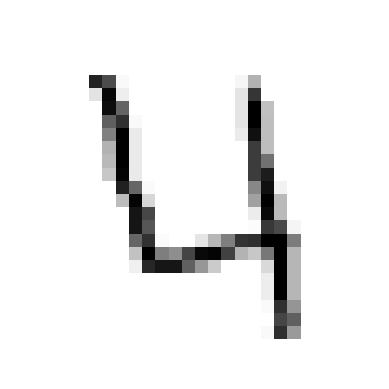

In [78]:
td = np.array(train_data)
plot_digit(td[3,1:])

**Preparing the data :**

In [79]:
Fours = train_data[train_data["label"]==4]
X_fours_data = np.array(Fours.iloc[:,1:])
y_fours_data = np.array(Fours.iloc[:,0])

In [80]:
Fours.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4072 entries, 3 to 41994
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 24.4 MB


In [81]:
j = 0
for i in X_fours_data :
    j = j + 1
    print(j*100/len(y_fours_data))
    t1 = shift(i.reshape(28,28),(1,-1))
    t2 = shift(i.reshape(28,28),(1,1))
    t3 = shift(i.reshape(28,28),(-1,1))
    t4 = shift(i.reshape(28,28),(-1,-1))
    t1 = np.insert(t1.reshape(1,-1),[0],4)
    t2 = np.insert(t2.reshape(1,-1),[0],4)
    t3 = np.insert(t3.reshape(1,-1),[0],4)
    t4 = np.insert(t4.reshape(1,-1),[0],4)
    t1 = pd.DataFrame(t1.reshape(1,785),index = [0],columns = train_data.columns)
    t2 = pd.DataFrame(t2.reshape(1,785),index = [1],columns = train_data.columns)
    t3 = pd.DataFrame(t3.reshape(1,785),index = [2],columns = train_data.columns)
    t4 = pd.DataFrame(t4.reshape(1,785),index = [3],columns = train_data.columns)
    t = pd.concat([t1,t2,t3,t4])
    train_data = pd.concat([train_data,t])
    clear_output()
    

47.22495088408645


KeyboardInterrupt: 

In [ ]:
X_train_data = np.array(train_data.iloc[:,1:])
y_train_data = np.array(train_data.iloc[:,0])


**Training and fine-tuning a Classifier:**

In [ ]:
knn_pipline = Pipeline([("classifier",KNeighborsClassifier(n_neighbors=5))])

In [ ]:
param_grid = [{'classifier__n_neighbors':[2,3,4,5,6],
               'classifier__weights':['uniform','distance']}]

In [ ]:
grid_search = GridSearchCV(knn_pipline,param_grid,cv=3,scoring = "accuracy")

In [ ]:
grid_search.fit(X_train_data,y_train_data)

In [ ]:
grid_search.best_params_

In [ ]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score",ascending=False,inplace=True)
cv_res

**Performance Measures:** 

In [ ]:
cross_val_score(grid_search,X_train_data,y_train_data,cv=3,scoring = "accuracy" )

In [ ]:
y_train_predict = cross_val_predict(grid_search,X_train_data,y_train_data,cv=3 )

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train_predict,np.array(train_data.iloc[:,0]),normalize="true",values_format=".0%")
plt.show()

In [ ]:
sample_weight = (y_train_predict != np.array(train_data.iloc[:,0]))
ConfusionMatrixDisplay.from_predictions(np.array(train_data.iloc[:,0]),y_train_predict,sample_weight=sample_weight,normalize="true",values_format=".0%")
plt.show()

**Evaluation :**

In [ ]:
final_evaluation = grid_search.predict(test_data)

In [ ]:
d = {'ImageId':np.arange(28000) + 1,'Label':final_evaluation}
df = pd.DataFrame(data=d)
df

In [ ]:
df.to_csv('out.csv',index=False)